In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train_v9rqX0R.csv')

In [6]:
a = train.isnull().sum()/len(train) * 100
a

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [7]:
# 1. Missing Value Ratio
variables = train.columns
variable = []  # only use these variables
for i in range(12):
    if (a[i] <= 20):
        variable.append(variables[i])

In [10]:
# 2. Low Variance Filter
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace = True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace = True)

In [11]:
train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

In [13]:
numeric = train[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']]
var = numeric.var()
numeric = numeric.columns
variable = []
for i in range(len(var)):
    if (var[i] >= 10):
        variable.append(numeric[i])

In [14]:
# 3. High Correlation Filter (consider dropping if over 0.5 - 0.6)
df = train.drop('Item_Outlet_Sales', 1)
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Weight,1.000000,-0.014168,0.024951,0.007739
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834
Item_MRP,0.024951,-0.001315,1.000000,0.005020
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000


In [15]:
# 4. Random Forest
from sklearn.ensemble import RandomForestRegressor
df = df.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1)
model = RandomForestRegressor(random_state = 1, max_depth = 10)
df = pd.get_dummies(df)
model.fit(df, train.Item_Outlet_Sales)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

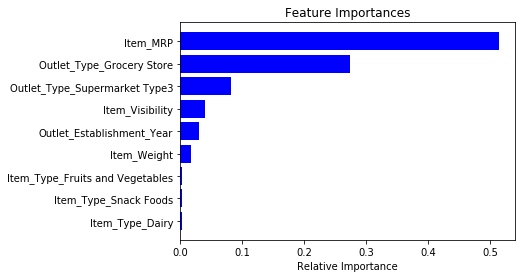

In [16]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
# OR, based on weights:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
Fit = feature.fit_transform(df, train.Item_Outlet_Sales) 

In [23]:
# 5. Backward Feature Elimination
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets
lreg = LinearRegression()
rfe = RFE(lreg, 10) # 10 features to select. worst dropped one by one
new_rfe = rfe.fit_transform(df, train.Item_Outlet_Sales)

In [24]:
rfe.ranking_ #?

array([25,  1, 16, 14,  5, 24,  6, 11,  1, 19, 23, 22, 10,  4, 15,  2, 21,
       17,  3, 20,  1,  1, 18,  1,  1,  9, 13,  7, 12, 26,  8,  1,  1,  1,
        1])

In [25]:
# 6. Forward Feature Selection
from sklearn.feature_selection import f_regression
ffs = f_regression(df, train.Item_Outlet_Sales)

In [26]:
variable = []
for i in range(len(df.columns) - 1):
    if (ffs[0][i] >= 10):
        variable.append(df.columns[i])

In [30]:
!/opt/anaconda3/bin/python -m pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 2.1 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3
    Uninstalling pip-20.3:
      Successfully uninstalled pip-20.3


In [32]:
!pip install cv

In [36]:
!pip install opencv-python

     |████████████████████████████████| 52.4 MB 3.4 MB/s eta 0:00:01     |███████████████████████████     | 44.2 MB 3.0 MB/s eta 0:00:03


In [41]:
# 7. Factor Analysis
from glob import glob
import cv2
images = [cv2.imread(file) for file in glob('train_LbELtWX/train/*.png')]

In [42]:
images = np.array(images)
images.shape

(60000, 28, 28, 3)

In [43]:
image = []
for i in range(60000):
    img = images[i].flatten()
    image.append(img)
image = np.array(image)

In [44]:
train = pd.read_csv('train_LbELtWX/train.csv')
feat_cols = ['pixel' + str(i) for i in range(image.shape[1])]
df = pd.DataFrame(image, columns = feat_cols)
df['label'] = train['label']

In [45]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components = 3).fit_transform(df[feat_cols].values)

<Figure size 432x288 with 0 Axes>

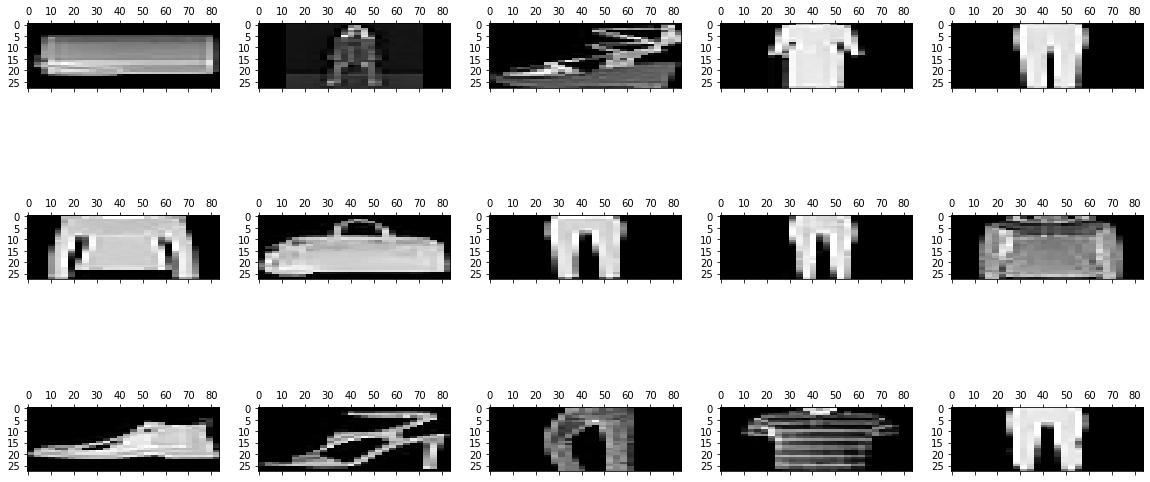

In [46]:
# 8. Principal Component Analysis
rndperm = np.random.permutation(df.shape[0])
plt.gray()
fig = plt.figure(figsize = (20, 10))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.matshow(df.loc[rndperm[i], feat_cols].values.reshape((28, 28*3)).astype(float))

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
pca_result = pca.fit_transform(df[feat_cols].values)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

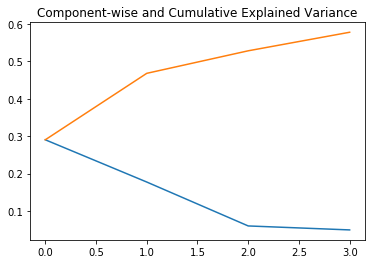

In [48]:
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

Text(0.5, 0.98, '4-Component PCA')

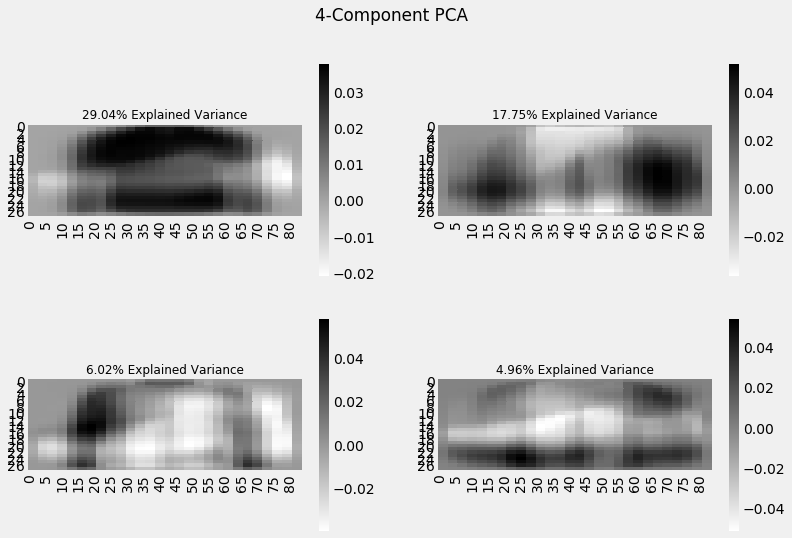

In [49]:
import seaborn as sns
plt.style.use('fivethirtyeight')
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
sns.heatmap(pca.components_[0, :].reshape(28, 84), ax=axarr[0][0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 84), ax=axarr[0][1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(28, 84), ax=axarr[1][0], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(28, 84), ax=axarr[1][1], cmap='gray_r')
axarr[0][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
fontsize=12
)
axarr[0][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
fontsize=12
)
axarr[1][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),
fontsize=12
)
axarr[1][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),
fontsize=12
)
axarr[0][0].set_aspect('equal')
axarr[0][1].set_aspect('equal')
axarr[1][0].set_aspect('equal')
axarr[1][1].set_aspect('equal')

plt.suptitle('4-Component PCA')


In [50]:
# Can also use Singular Value Decomposition (SVD), which decomposes the original variables into 3 constituent
# matrices
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 3, random_state = 42).fit_transform(df[feat_cols].values)

In [51]:
# 9. Independent Component Analysis (ICA)
# Most common measure of independece of components is non-Gaussianity
# Maximize kurtosis of the ind. components (3rd order moment of the dist.)
# This will make dist. non-gaussian and hence we will get independent components
from sklearn.decomposition import FastICA
ICA = FastICA(n_components = 3, random_state = 12)
X = ICA.fit_transform(df[feat_cols].values)

In [52]:
# 10. Methods Based on Projections
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(df[feat_cols][:6000].values)

In [53]:
# 11. t-Distributed Stochastic Neighbor Embedding (t-SNE)
# search for non-linear patterns
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3, n_iter=300).fit_transform(df[feat_cols][:6000].values)

In [54]:
# 12. UMAP (Uniform Manifold Approximation and Projection (UMAP))
# uses knn concept and optimizes using SGD. minimize distances between
# points in low-dimensional space
import umap
umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform(df[feat_cols][:6000].values)

ModuleNotFoundError: No module named 'umap'